In [59]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [60]:
vague_position_model_data = pd.read_csv('vague_position_model_data.csv')

In [61]:
comprehensive_vague_positions_df = pd.read_csv('comprehensive_vague_positions_df.csv')

In [62]:
vague_position_model_data.head(20)

,Age,In Squad,Appearances,Goals,Assists,Yellow Cards,Second Yellows,Straight Reds,Substituted On,Substituted Off,...,TOTY_Nominee,League_bundesliga,League_laliga,League_ligue-1,League_premier-league,League_serie-a,Position_Attacker,Position_Defender,Position_Goalkeeper,Position_Midfielder
0,26,52,49,0,0,3,0,0,0,0,...,0,False,True,False,False,False,False,False,True,False
1,32,51,11,0,0,1,0,0,0,0,...,0,False,True,False,False,False,False,False,True,False
2,21,51,23,0,0,3,0,1,7,0,...,0,False,True,False,False,False,False,True,False,False
3,21,50,45,3,1,7,2,0,1,1,...,0,False,True,False,False,False,False,True,False,False
4,29,41,37,3,3,7,1,0,1,8,...,0,False,True,False,False,False,False,True,False,False
5,30,49,45,1,3,8,0,0,4,6,...,1,False,True,False,False,False,False,True,False,False
6,34,49,30,1,2,0,0,0,8,4,...,0,False,True,False,False,False,False,True,False,False
7,25,54,54,5,14,13,0,0,2,4,...,0,False,True,False,False,False,False,True,False,False
8,28,39,32,0,1,6,0,2,1,2,...,0,False,True,False,False,False,False,True,False,False
9,19,53,41,3,1,12,0,0,10,8,...,0,False,True,False,False,False,False,False,False,True


In [63]:
# define a dictionary mapping test seasons to their corresponding mapped values need to reverse search player names
test_season_dict = {
    '2020/2021': 13,
    '2021/2022': 14,
    '2022/2023': 15,
    '2023/2024': 16
}

In [64]:
#function to find players based on input criteria, to be used in position_named
def find_players(appearances, goals, assists, placement, season_num):
    #grab the corresponding season string from test dict
    season_str = None
    for str_season, num_season in test_season_dict.items():
        if num_season == season_num:
            season_str = str_season
            break

    if not season_str:
        print(f"Error: Season number {season_num} not found in test_season_dict.")
        return []

    #filter the df based on the input criteria and match the season string
    filtered_df = comprehensive_vague_positions_df[
        (comprehensive_vague_positions_df['Appearances'] == appearances) & 
        (comprehensive_vague_positions_df['Goals'] == goals) & 
        (comprehensive_vague_positions_df['Assists'] == assists) & 
        (comprehensive_vague_positions_df['Placement'] == placement) & 
        (comprehensive_vague_positions_df['Season'] == season_str)
    ]
    
    # return the matching player names
    return filtered_df['Player'].tolist()

In [65]:
#function to print top N players for a given one-hot encoded position, not in final version
def print_top_n_for_position(position_prefix, n):
    filtered_data = test_data[test_data[position_prefix] == 1]
    top_n_players = filtered_data.nlargest(n, 'Probability')
    print(f"\nTop {n} {position_prefix.replace('Position_', '')}s:")
    print(top_n_players[['Probability', 'Appearances', 'Goals', 'Assists', 'Placement']])

In [66]:
#function to print top N players for a given one-hot encoded position
def print_top_n_for_position_named(position_prefix, n, season_num):
    filtered_data = test_data[test_data[position_prefix] == 1]
    top_n_players = filtered_data.nlargest(n, 'Probability')
    print(f"\nTop {n} {position_prefix.replace('Position_', '')}s:")
    for _, row in top_n_players.iterrows():
        # Use the updated find_players function to get player names
        player_names = find_players(
            row['Appearances'], 
            row['Goals'], 
            row['Assists'], 
            row['Placement'], 
            season_num
        )
        
        # If players are found, print their details
        if player_names:
            for player_name in player_names:
                print(f"Player: {player_name}, Probability: {row['Probability']:.2f}, Appearances: {row['Appearances']}, Goals: {row['Goals']}, Assists: {row['Assists']}, Placement: {row['Placement']}")
        else:
            print(f"No matching players found for Appearances: {row['Appearances']}, Goals: {row['Goals']}, Assists: {row['Assists']}, Placement: {row['Placement']}")

In [67]:
#Initial Classifier without threshold (unrefined model)

In [68]:
#Probability Classifier

#define the cutoff for training and test data
train_cutoff = 12
test_season = 16

#separate the data into training and test sets
train_data = vague_position_model_data[vague_position_model_data['Season'] <= train_cutoff]
test_data = vague_position_model_data[vague_position_model_data['Season'] == test_season]

#drop the TOTY and TOTY_Nominee columns, as instructed
X_train = train_data.drop(columns=['TOTY', 'TOTY_Nominee'])
y_train = train_data['TOTY_Nominee']
X_test = test_data.drop(columns=['TOTY', 'TOTY_Nominee'])
y_test = test_data['TOTY_Nominee']

print("Training data and test data separated successfully.")


#standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Model trained successfully.")

#evaluate the model
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f'Train Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1 Score: {test_f1:.2f}')

#predict probabilities on the test set
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of class 1

#one-hot encoded position columns
position_columns = ['Position_Goalkeeper', 'Position_Defender', 'Position_Midfielder', 'Position_Attacker']

#combine probabilities with the original test data to find the positions
test_data['Probability'] = probabilities

#define the top N for each position category
top_n = {
    'Goalkeeper': 1,
    'Defender': 4,
    'Midfielder': 3,
    'Attacker': 3
}


#print the top probabilities for each position - original without names
for position, n in top_n.items():
    position_prefix = f'Position_{position}'
    print_top_n_for_position(position_prefix, n)


#print the top probabilities for each position - updated with names
for position, n in top_n.items():
    position_prefix = f'Position_{position}'
    print_top_n_for_position_named(position_prefix, n, test_season)

Training data and test data separated successfully.
Model trained successfully.
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.97, Precision: 0.50, Recall: 0.07, F1 Score: 0.12

Top 1 Goalkeepers:
      Probability  Appearances  Goals  Assists  Placement
6466     0.444931           36      0        0          2

Top 4 Defenders:
       Probability  Appearances  Goals  Assists  Placement
6447      0.662148           48      2        3          1
19032     0.653132           51     12       20          1
6451      0.576436           41      6        5          1
6453      0.437400           45      0        1          1

Top 3 Midfielders:
       Probability  Appearances  Goals  Assists  Placement
6454      0.787075           42     23       13          1
13215     0.721335           50      9       14          1
6455      0.460035           54      3        8          1

Top 3 Attackers:
       Probability  Appearances  Goals  Assists  Placement
132

C:\Users\haiaj\AppData\Local\Temp\ipykernel_34460\4242662202.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Probability'] = probabilities


In [69]:
# INITIAL THRESHOLD TEST

In [70]:
#TESTING SAME THING FOR THRESHOLD

#probability Classifier
#define the cutoff for training and test data
train_cutoff = 12
test_season = 16

#separate the data into training and test sets
train_data = vague_position_model_data[vague_position_model_data['Season'] <= train_cutoff]
test_data = vague_position_model_data[vague_position_model_data['Season'] == test_season]

#drop the TOTY and TOTY_Nominee columns, as instructed
X_train = train_data.drop(columns=['TOTY', 'TOTY_Nominee'])
y_train = train_data['TOTY_Nominee']
X_test = test_data.drop(columns=['TOTY', 'TOTY_Nominee'])
y_test = test_data['TOTY_Nominee']

print("Training data and test data separated successfully.")

#standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Model trained successfully.")

#predict probabilities on the test set
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of class 1

#set a custom threshold (e.g., 0.3)
threshold = 0.25

#convert probabilities to binary predictions using the custom threshold
y_test_pred_custom = (probabilities >= threshold).astype(int)

#evaluate the model with the custom threshold
test_accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
test_precision_custom = precision_score(y_test, y_test_pred_custom)
test_recall_custom = recall_score(y_test, y_test_pred_custom)
test_f1_custom = f1_score(y_test, y_test_pred_custom)

print(f'Test Accuracy (Threshold={threshold}): {test_accuracy_custom:.2f}')
print(f'Test Precision (Threshold={threshold}): {test_precision_custom:.2f}')
print(f'Test Recall (Threshold={threshold}): {test_recall_custom:.2f}')
print(f'Test F1 Score (Threshold={threshold}): {test_f1_custom:.2f}')

#assuming one-hot encoded position columns
position_columns = ['Position_Goalkeeper', 'Position_Defender', 'Position_Midfielder', 'Position_Attacker']

#combine probabilities with the original test data to find the positions
test_data['Probability'] = probabilities

#define the top N for each position category
top_n = {
    'Goalkeeper': 1,
    'Defender': 4,
    'Midfielder': 3,
    'Attacker': 3
}

#print the top probabilities for each position
for position, n in top_n.items():
    position_prefix = f'Position_{position}'
    print_top_n_for_position(position_prefix, n)

#print the top probabilities for each position
for position, n in top_n.items():
    position_prefix = f'Position_{position}'
    print_top_n_for_position_named(position_prefix, n, test_season)

Training data and test data separated successfully.
Model trained successfully.
Test Accuracy (Threshold=0.25): 0.97
Test Precision (Threshold=0.25): 0.59
Test Recall (Threshold=0.25): 0.39
Test F1 Score (Threshold=0.25): 0.47

Top 1 Goalkeepers:
      Probability  Appearances  Goals  Assists  Placement
6466     0.444931           36      0        0          2

Top 4 Defenders:
       Probability  Appearances  Goals  Assists  Placement
6447      0.662148           48      2        3          1
19032     0.653132           51     12       20          1
6451      0.576436           41      6        5          1
6453      0.437400           45      0        1          1

Top 3 Midfielders:
       Probability  Appearances  Goals  Assists  Placement
6454      0.787075           42     23       13          1
13215     0.721335           50      9       14          1
6455      0.460035           54      3        8          1

Top 3 Attackers:
       Probability  Appearances  Goals  Assists  P

C:\Users\haiaj\AppData\Local\Temp\ipykernel_34460\3296305512.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Probability'] = probabilities


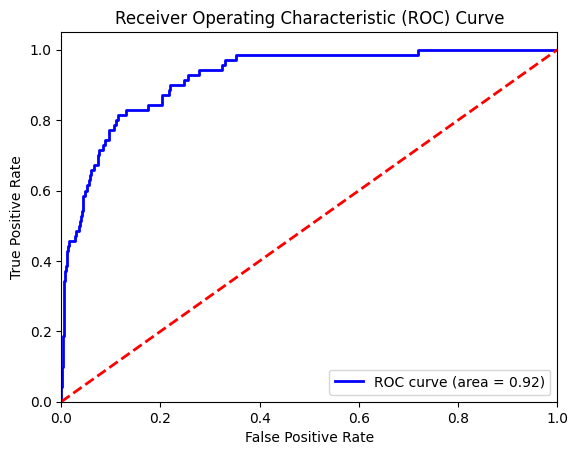

Optimal threshold: 0.02
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.97, Precision: 0.50, Recall: 0.07, F1 Score: 0.12


In [71]:
#predict probabilities on the test set
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of class 1

#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

#calculate AUC
roc_auc = roc_auc_score(y_test, probabilities)

#plot
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#find the optimal threshold
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f'Optimal threshold: {optimal_threshold:.2f}')

print(f'Train Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1 Score: {test_f1:.2f}')


Evaluating for season: 2020/2021
Training data and test data separated successfully.
Model trained successfully.
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.99, Precision: 0.50, Recall: 0.10, F1 Score: 0.17

Top 1 Goalkeepers for season 2020/2021:
Error: Season number 2020/2021 not found in test_season_dict.

Top 4 Defenders for season 2020/2021:
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 not found in test_season_dict.

Top 3 Midfielders for season 2020/2021:
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 not found in test_season_dict.

Top 3 Attackers for season 2020/2021:
Error: Season number 2020/2021 not found in test_season_dict.
Error: Season number 2020/2021 no

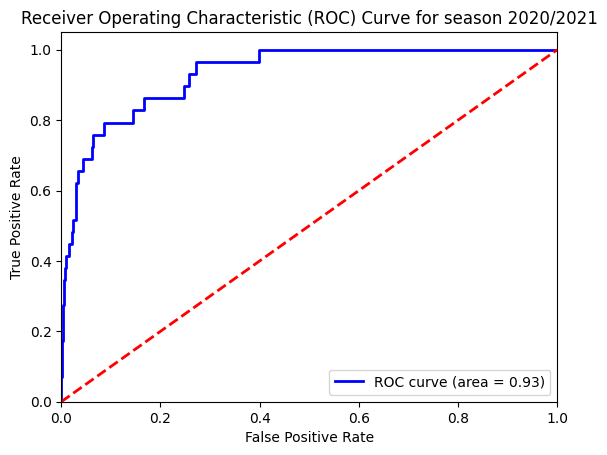


Evaluating for season: 2021/2022
Training data and test data separated successfully.
Model trained successfully.
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.97, Precision: 0.53, Recall: 0.11, F1 Score: 0.18

Top 1 Goalkeepers for season 2021/2022:
Error: Season number 2021/2022 not found in test_season_dict.

Top 4 Defenders for season 2021/2022:
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 not found in test_season_dict.

Top 3 Midfielders for season 2021/2022:
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 not found in test_season_dict.

Top 3 Attackers for season 2021/2022:
Error: Season number 2021/2022 not found in test_season_dict.
Error: Season number 2021/2022 no

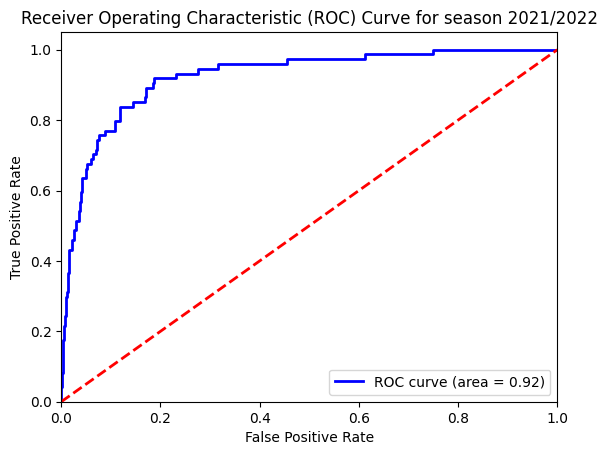


Evaluating for season: 2022/2023
Training data and test data separated successfully.
Model trained successfully.
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.96, Precision: 0.86, Recall: 0.07, F1 Score: 0.13

Top 1 Goalkeepers for season 2022/2023:
Error: Season number 2022/2023 not found in test_season_dict.

Top 4 Defenders for season 2022/2023:
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 not found in test_season_dict.

Top 3 Midfielders for season 2022/2023:
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 not found in test_season_dict.

Top 3 Attackers for season 2022/2023:
Error: Season number 2022/2023 not found in test_season_dict.
Error: Season number 2022/2023 no

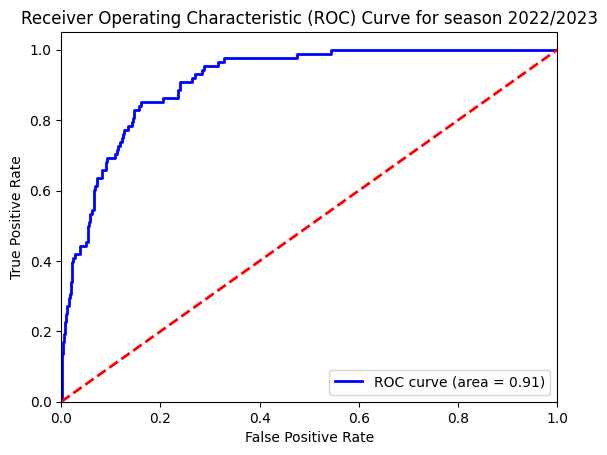


Evaluating for season: 2023/2024
Training data and test data separated successfully.
Model trained successfully.
Train Accuracy: 0.98, Precision: 0.65, Recall: 0.24, F1 Score: 0.36
Test Accuracy: 0.97, Precision: 0.50, Recall: 0.07, F1 Score: 0.12

Top 1 Goalkeepers for season 2023/2024:
Error: Season number 2023/2024 not found in test_season_dict.

Top 4 Defenders for season 2023/2024:
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 not found in test_season_dict.

Top 3 Midfielders for season 2023/2024:
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 not found in test_season_dict.

Top 3 Attackers for season 2023/2024:
Error: Season number 2023/2024 not found in test_season_dict.
Error: Season number 2023/2024 no

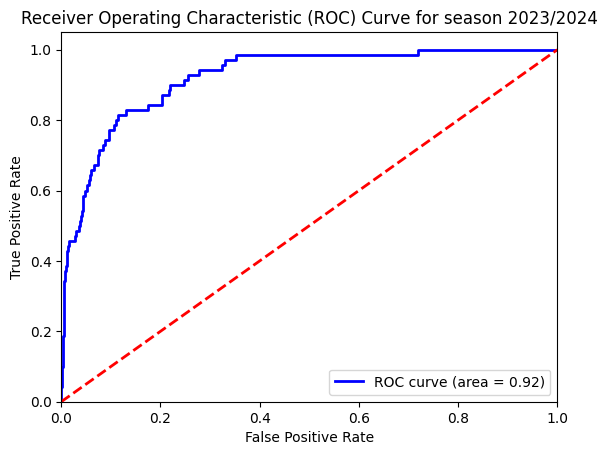

In [72]:
#loop through each season in the test data
for season in sorted(vague_position_model_data['Season'].unique()):
    if season <= train_cutoff:
        continue  #skip the training seasons

    #check if the current season is in the test dict
    season_str = None
    for key, value in test_season_dict.items():
        if value == season:
            season_str = key
            break

    if season_str is None:
        continue  # Skip seasons not in the test_season_dict

    print(f"\nEvaluating for season: {season_str}")

    #separate the data into training and test sets
    train_data = vague_position_model_data[vague_position_model_data['Season'] <= train_cutoff]
    test_data = vague_position_model_data[vague_position_model_data['Season'] == season]

    #drop the TOTY and TOTY_Nominee columns
    X_train = train_data.drop(columns=['TOTY', 'TOTY_Nominee'])
    y_train = train_data['TOTY_Nominee']
    X_test = test_data.drop(columns=['TOTY', 'TOTY_Nominee'])
    y_test = test_data['TOTY_Nominee']

    print("Training data and test data separated successfully.")

    #standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    print("Model trained successfully.")

    #evaluate the model
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f'Train Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}')
    print(f'Test Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1 Score: {test_f1:.2f}')

    #predict probabilities on the test set
    probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of class 1

    #combine probabilities with the original test data to find the positions
    test_data = test_data.copy()  # Avoid SettingWithCopyWarning
    test_data['Probability'] = probabilities

    #print the top probabilities for each position
    for position, n in top_n.items():
        position_prefix = f'Position_{position}'
        filtered_data = test_data.loc[test_data[position_prefix] == 1]
        top_n_players = filtered_data.nlargest(n, 'Probability')

        print(f"\nTop {n} {position_prefix.replace('Position_', '')}s for season {season_str}:")

        for index, row in top_n_players.iterrows():
            appearances = row['Appearances']
            goals = row['Goals']
            assists = row['Assists']
            placement = row['Placement']

            #find players in comprehensive_vague_positions_df that match the stats for this season
            player_names = find_players(appearances, goals, assists, placement, season_str)

            for player_name in player_names:
                print(f"Player: {player_name}, Appearances: {appearances}, Goals: {goals}, Assists: {assists}, Placement: {placement}, Probability: {row['Probability']:.2f}")

    #calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)

    #calculate AUC
    roc_auc = roc_auc_score(y_test, probabilities)

    #plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for season {season_str}')
    plt.legend(loc="lower right")
    plt.show()


Evaluating for season: 2020/2021
Training data and test data separated successfully.
Model trained successfully.
Test Accuracy (Threshold=0.25): 0.98
Test Precision (Threshold=0.25): 0.37
Test Recall (Threshold=0.25): 0.38
Test F1 Score (Threshold=0.25): 0.37

Top 1 Goalkeepers for season 2020/2021:
Player: jan oblak, Appearances: 46, Goals: 0, Assists: 0, Placement: 1, Probability: 0.45
Player: manuel neuer, Appearances: 46, Goals: 0, Assists: 0, Placement: 1, Probability: 0.45

Top 4 Defenders for season 2020/2021:
Player: jordi alba, Appearances: 49, Goals: 5, Assists: 15, Placement: 3, Probability: 0.54
Player: stefan savic, Appearances: 42, Goals: 1, Assists: 0, Placement: 1, Probability: 0.49
Player: stefan de vrij, Appearances: 42, Goals: 1, Assists: 0, Placement: 1, Probability: 0.49
Player: joshua kimmich, Appearances: 39, Goals: 6, Assists: 14, Placement: 1, Probability: 0.39
Player: kieran trippier, Appearances: 35, Goals: 0, Assists: 6, Placement: 1, Probability: 0.34

Top

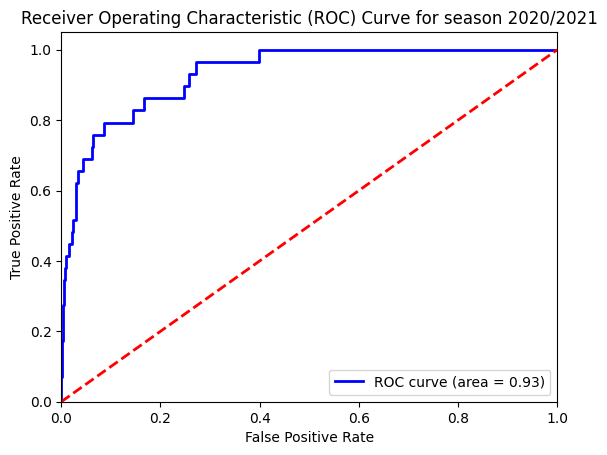


Evaluating for season: 2021/2022
Training data and test data separated successfully.
Model trained successfully.
Test Accuracy (Threshold=0.25): 0.97
Test Precision (Threshold=0.25): 0.50
Test Recall (Threshold=0.25): 0.24
Test F1 Score (Threshold=0.25): 0.33

Top 1 Goalkeepers for season 2021/2022:
Player: thibaut courtois, Appearances: 52, Goals: 0, Assists: 0, Placement: 1, Probability: 0.70

Top 4 Defenders for season 2021/2022:
Player: eder militao, Appearances: 50, Goals: 2, Assists: 3, Placement: 1, Probability: 0.61
Player: joao cancelo, Appearances: 52, Goals: 3, Assists: 10, Placement: 1, Probability: 0.60
Player: david alaba, Appearances: 46, Goals: 3, Assists: 4, Placement: 1, Probability: 0.60
Player: virgil van dijk, Appearances: 51, Goals: 3, Assists: 3, Placement: 2, Probability: 0.57

Top 3 Midfielders for season 2021/2022:
Player: kevin de bruyne, Appearances: 45, Goals: 19, Assists: 15, Placement: 1, Probability: 0.44
Player: luka modric, Appearances: 45, Goals: 3, 

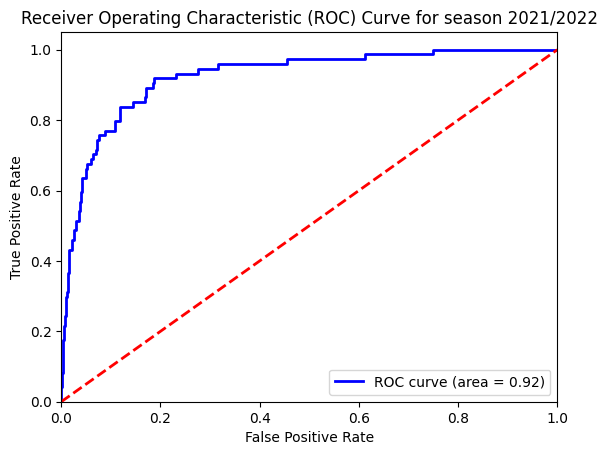


Evaluating for season: 2022/2023
Training data and test data separated successfully.
Model trained successfully.
Test Accuracy (Threshold=0.25): 0.96
Test Precision (Threshold=0.25): 0.57
Test Recall (Threshold=0.25): 0.23
Test F1 Score (Threshold=0.25): 0.33

Top 1 Goalkeepers for season 2022/2023:
Player: thibaut courtois, Appearances: 49, Goals: 0, Assists: 0, Placement: 2, Probability: 0.51

Top 4 Defenders for season 2022/2023:
Player: manuel akanji, Appearances: 48, Goals: 1, Assists: 1, Placement: 1, Probability: 0.45
Player: joshua kimmich, Appearances: 47, Goals: 7, Assists: 11, Placement: 1, Probability: 0.38
Player: joao cancelo, Appearances: 26, Goals: 2, Assists: 5, Placement: 1, Probability: 0.33
Player: ruben dias, Appearances: 43, Goals: 1, Assists: 0, Placement: 1, Probability: 0.32

Top 3 Midfielders for season 2022/2023:
Player: kevin de bruyne, Appearances: 49, Goals: 10, Assists: 31, Placement: 1, Probability: 0.66
Player: bruno fernandes, Appearances: 59, Goals: 

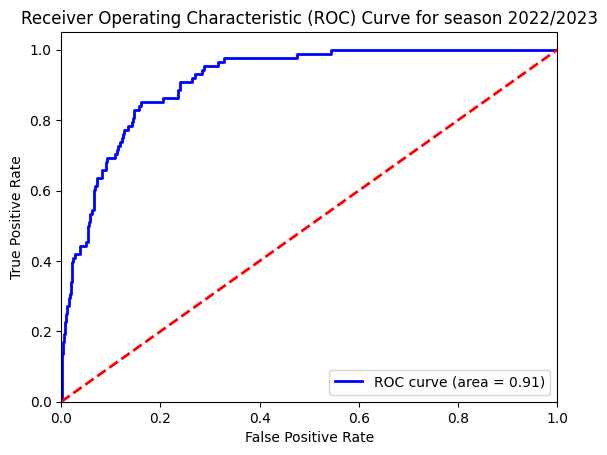


Evaluating for season: 2023/2024
Training data and test data separated successfully.
Model trained successfully.
Test Accuracy (Threshold=0.25): 0.97
Test Precision (Threshold=0.25): 0.59
Test Recall (Threshold=0.25): 0.39
Test F1 Score (Threshold=0.25): 0.47

Top 1 Goalkeepers for season 2023/2024:
Player: marc-andre ter stegen, Appearances: 36, Goals: 0, Assists: 0, Placement: 2, Probability: 0.44

Top 4 Defenders for season 2023/2024:
Player: antonio rudiger, Appearances: 48, Goals: 2, Assists: 3, Placement: 1, Probability: 0.66
Player: alejandro grimaldo, Appearances: 51, Goals: 12, Assists: 20, Placement: 1, Probability: 0.65
Player: daniel carvajal, Appearances: 41, Goals: 6, Assists: 5, Placement: 1, Probability: 0.58
Player: nacho fernandez, Appearances: 45, Goals: 0, Assists: 1, Placement: 1, Probability: 0.44

Top 3 Midfielders for season 2023/2024:
Player: jude bellingham, Appearances: 42, Goals: 23, Assists: 13, Placement: 1, Probability: 0.79
Player: rodri, Appearances: 5

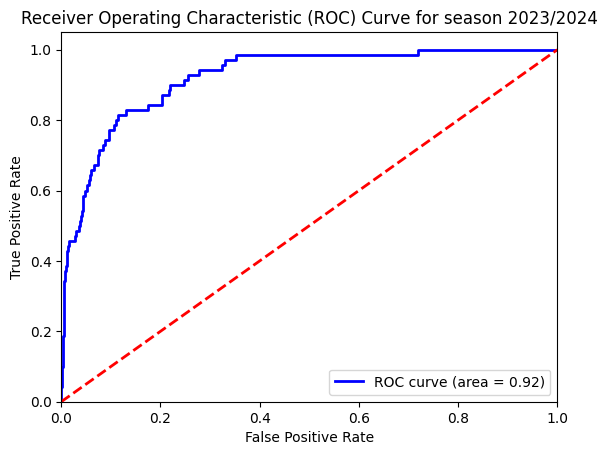

In [73]:
#custom threshold
threshold = 0.25

#loop through each season in the test data
for season in sorted(vague_position_model_data['Season'].unique()):
    if season <= train_cutoff:
        continue  #skip training seasons

    #check if the current season is in the test_season_dict
    season_str = None
    for key, value in test_season_dict.items():
        if value == season:
            season_str = key
            break

    if season_str is None:
        continue  #skip seasons not in the test dict

    print(f"\nEvaluating for season: {season_str}")

    #separate the data into training and test sets
    train_data = vague_position_model_data[vague_position_model_data['Season'] <= train_cutoff]
    test_data = vague_position_model_data[vague_position_model_data['Season'] == season]

    #drop the TOTY and TOTY_Nominee columns
    X_train = train_data.drop(columns=['TOTY', 'TOTY_Nominee'])
    y_train = train_data['TOTY_Nominee']
    X_test = test_data.drop(columns=['TOTY', 'TOTY_Nominee'])
    y_test = test_data['TOTY_Nominee']

    print("Training data and test data separated successfully.")

    #standardize the features so we don't give more value to wider ranges
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    print("Model trained successfully.")

    #predict probabilities on the test set
    probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities of class 1

     #convert probabilities to binary predictions using custom threshold
    y_test_pred_custom = (probabilities >= threshold).astype(int)

    # Evaluate the model with the custom threshold
    test_accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
    test_precision_custom = precision_score(y_test, y_test_pred_custom)
    test_recall_custom = recall_score(y_test, y_test_pred_custom)
    test_f1_custom = f1_score(y_test, y_test_pred_custom)

    print(f'Test Accuracy (Threshold={threshold}): {test_accuracy_custom:.2f}')
    print(f'Test Precision (Threshold={threshold}): {test_precision_custom:.2f}')
    print(f'Test Recall (Threshold={threshold}): {test_recall_custom:.2f}')
    print(f'Test F1 Score (Threshold={threshold}): {test_f1_custom:.2f}')

    #combine probabilities with the original test data to find the positions
    test_data = test_data.copy()
    test_data['Probability'] = probabilities

    #print top probabilities for each position
    for position, n in top_n.items():
        position_prefix = f'Position_{position}'
        filtered_data = test_data.loc[test_data[position_prefix] == 1]
        top_n_players = filtered_data.nlargest(n, 'Probability')

        print(f"\nTop {n} {position_prefix.replace('Position_', '')}s for season {season_str}:")

        for index, row in top_n_players.iterrows():
            appearances = row['Appearances']
            goals = row['Goals']
            assists = row['Assists']
            placement = row['Placement']

            #find players in comprehensive_vague_positions_df that match the stats for this season
            player_names = find_players(appearances, goals, assists, placement, season)

            for player_name in player_names:
                print(f"Player: {player_name}, Appearances: {appearances}, Goals: {goals}, Assists: {assists}, Placement: {placement}, Probability: {row['Probability']:.2f}")

    #calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)

    #calculate AUC
    roc_auc = roc_auc_score(y_test, probabilities)

    #plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for season {season_str}')
    plt.legend(loc="lower right")
    plt.show()

In [57]:
# # Function to print top N players for a given one-hot encoded position
# def print_top_n_for_position(position_prefix, n):
#     filtered_data = test_data[test_data[position_prefix] == 1]
#     top_n_players = filtered_data.nlargest(n, 'Probability')
#     print(f"\nTop {n} {position_prefix.replace('Position_', '')}s:")
#     for _, row in top_n_players.iterrows():
#         players = find_players(row['Appearances'], row['Goals'], row['Assists'], row['Placement'], '2023/2024', comprehensive_vague_positions_df)
#         if not players.empty:
#             for _, player_row in players.iterrows():
#                 print(f"Player: {player_row['Player']}, Probability: {row['Probability']:.2f}, Appearances: {row['Appearances']}, Goals: {row['Goals']}, Assists: {row['Assists']}, Placement: {row['Placement']}")

# # Print the top probabilities for each position
# for position, n in top_n.items():
#     position_prefix = f'Position_{position}'
#     print_top_n_for_position(position_prefix, n)


Top 1 Goalkeepers:
Player: marc-andre ter stegen, Probability: 0.44, Appearances: 36, Goals: 0, Assists: 0, Placement: 2

Top 4 Defenders:
Player: antonio rudiger, Probability: 0.66, Appearances: 48, Goals: 2, Assists: 3, Placement: 1
Player: alejandro grimaldo, Probability: 0.65, Appearances: 51, Goals: 12, Assists: 20, Placement: 1
Player: daniel carvajal, Probability: 0.58, Appearances: 41, Goals: 6, Assists: 5, Placement: 1
Player: nacho fernandez, Probability: 0.44, Appearances: 45, Goals: 0, Assists: 1, Placement: 1

Top 3 Midfielders:
Player: jude bellingham, Probability: 0.79, Appearances: 42, Goals: 23, Assists: 13, Placement: 1
Player: rodri, Probability: 0.72, Appearances: 50, Goals: 9, Assists: 14, Placement: 1
Player: federico valverde, Probability: 0.46, Appearances: 54, Goals: 3, Assists: 8, Placement: 1

Top 3 Attackers:
Player: erling haaland, Probability: 0.70, Appearances: 45, Goals: 38, Assists: 6, Placement: 1
Player: vinicius junior, Probability: 0.67, Appearance

In [74]:
#function to find players based on input criteria
def find_players(appearances, goals, assists, placement, season, df):
    #filter the df based on the input criteria
    filtered_df = df[
        (df['Appearances'] == appearances) & 
        (df['Goals'] == goals) & 
        (df['Assists'] == assists) & 
        (df['Placement'] == placement) & 
        (df['Season'] == season)
    ]
    #return the filtered df with all original columns
    return filtered_df

#test
example_appearances = 52
example_goals = 3
example_assists = 10
example_placement = 1
example_season = '2021/2022'

result = find_players(example_appearances, example_goals, example_assists, example_placement, example_season, comprehensive_vague_positions_df)
result

,Player,Age,Position,Kit Number,Nationality,In Squad,Appearances,Goals,Assists,Yellow Cards,...,Minutes Played,Club,Season,Team,Placement,League,Champions League,Domestic Cup,TOTY,TOTY_Nominee
20777,joao cancelo,27,Defender,27,Portugal,54,52,3,10,10,...,4623.0,Manchester City,2021/2022,manchester-city,1,premier-league,0,0,0,0


In [ ]:
#add a function that will go over your results and search them so you automatically get the names